Importa o modelo a ser fatiado e mapeado

In [1]:
import matplotlib.pyplot as plt
import gui
import files
from timer import Timer
from components.layer import Layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
choice = gui.ask_load_or_begin()
if choice == "Novo Projeto":
    path_input, file_name = gui.load_model(folders)
    [dpi, layer_height] = gui.ask_parameters_input()
    with Timer("Fase 0: "):
        Layer.create_layers(folders, path_input, file_name, dpi, layer_height)
elif choice == "Carregar Salvo":
    gui.find_saved_file(folders)
elif choice == "Cancelar":
    quit

#TODO: encontrar uma forma de jogar layerHight para o slicing W/images (POSSIVELMENTE COM O RUNSINGLEMODEL)

Fase 0: 
criando as camadas
First arg: /home/matheus/Downloads/Tangran3/TangranV2/input/stl_models/cubo70.STL
Second arg: 300.0
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2/input/sliced
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2/slicing-with-images
number of degenerated triangles = 0
eps = 0.004
max thickness = 2
rounded plane spacing spacing = 2
model zmin = 0, model zmax = 20, first plane Z = -1.996, number of planes = 12
-Incremental, cubo70.STL, thickness = 2, #T = 176, #P = 10, #S = 880, 0.000469s (slicing), 0.00109s (polygon assembling), 0.006977s (total), *K: 5


rm: cannot remove '*.svg': No such file or directory
rm: cannot remove '*.png': No such file or directory




writing image: ../input/sliced/layer_000.pgm


writing image: ../input/sliced/layer_001.pgm


writing image: ../input/sliced/layer_002.pgm


writing image: ../input/sliced/layer_003.pgm


writing image: ../input/sliced/layer_004.pgm


writing image: ../input/sliced/layer_005.pgm


writing image: ../input/sliced/layer_006.pgm


writing image: ../input/sliced/layer_007.pgm


writing image: ../input/sliced/layer_008.pgm


writing image: ../input/sliced/layer_009.pgm


writing output file: out_3d.svg
... done


Total de [criando as camadas] : 2.3513057231903076
salvando as camadas
Total de [salvando as camadas] : 0.6057374477386475
Total de [Fase 0: ] : 2.958832263946533


Paredes Finas

In [2]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[nozzle_diam_internal,nozzle_diam_external] = gui.ask_parameters_thin_walls()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 1: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_thin_walls(folders, nozzle_diam_external, nozzle_diam_internal)
        %reset_selective -f "c"
%reset_selective -f "camadas"
# TODO: arvore de paredes finas
# TODO: quando duas áreas se encontram
# TODO: limite de parede diam minimo
# TODO: anotar todos os (não fechou contorno)
# TODO arrumar para origens extremamente pequenas, ignorar da problema
# TODO arrumar casos onde a beirada esta vazndo criando areas triangulares distantes
# FIXME: Precisa mesmo separar linha 1 2 topo e baixo? muitos elementos estão sendo criados

Fase 1: Camada: 0
Criando paredes finas
Total de [Criando paredes finas] : 2.986330032348633
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0014107227325439453
salvando imagens das regiões
ERRO: não deletou a coisa
Total de [salvando imagens das regiões] : 0.039704322814941406
Total de [Fase 1: Camada: 0] : 3.0392205715179443
Fase 1: Camada: 1
Criando paredes finas
Total de [Criando paredes finas] : 2.9018633365631104
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0002903938293457031
salvando imagens das regiões
ERRO: não deletou a coisa
Total de [salvando imagens das regiões] : 0.025842905044555664
Total de [Fase 1: Camada: 1] : 2.9432921409606934
Fase 1: Camada: 2
Criando paredes finas
Total de [Criando paredes finas] : 2.8823466300964355
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0058667659759521484
salvando imagens das regiões
ERRO: não deletou a coisa
Total de [salvando 

Contornos

In [3]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[void_max,internal_max,external_max] = gui.ask_parameters_offsets()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 2: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_offsets(folders, void_max, external_max, internal_max)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 2: Camada: 0
Criando Lvls
Ilha: I_000 Número de Níveis: 2
Total de [Criando Lvls] : 2.6893301010131836
Criando os loops
Total de [Criando os loops] : 0.9441275596618652
Criando regiões de influência
Total de [Criando regiões de influência] : 0.17942070960998535
Criando as regiões de Offset
Total de [Criando as regiões de Offset] : 1.3425414562225342
Retirando regiões da camada
['Lvl_000', 0, 0] Perdendo total:3227 maior void:0.3069608216051731Bw -> aceito
['Lvl_000', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_001', 0, 0] Perdendo total:28348 maior void:9.548117154811715Bw -> bloqueado
['Lvl_001', 0, 1] Perdendo total:28348 maior void:9.547736782046405Bw -> bloqueado
['Lvl_001', 0, 2] Perdendo total:4921 maior void:0.5968048687713959Bw -> bloqueado
['Lvl_001', 0, 3] Perdendo total:51395 maior void:9.475846329402815Bw -> bloqueado
Total de [Retirando regiões da camada] : 0.7425787448883057
Reunindo todos os loops em uma unica imagem
Total de [Reunindo todos os loops em um

Pontes

In [32]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
import numpy as np
from components import images_tools as it

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[n_max, nozzle_diam_internal] = gui.ask_parameters_bridges()
camadas = folders.load_layers_hdf5()
last_prohibited_areas = np.zeros(camadas[0].base_frame)
for i,c in enumerate(camadas):
    with Timer("Fase 3: Camada: " + str(i)):
        if i%2 == 1:
            last_image = it.rotate_img_cw(last_prohibited_areas )
        elif i%2 == 0:
            last_image = it.rotate_img_ccw(last_prohibited_areas )
        if i >= 2:
            if i%2 == 1:
                second_last_image = it.rotate_img_cw(camadas[i - 1].prohibited_areas)
            elif i%2 == 0:
                second_last_image = it.rotate_img_ccw(camadas[i - 1].prohibited_areas)
        else:
            second_last_image = np.zeros_like(last_image)
        c.prohibited_areas = last_image
        sum_prohibited_areas = it.sum_imgs([last_image, second_last_image])
        last_prohibited_areas = c.make_bridges(n_max, nozzle_diam_internal, folders, len(camadas), sum_prohibited_areas)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        # %reset_selective -f "c" 
# %reset_selective -f "camadas"

Fase 3: Camada: 0
Criando pontes de Offset
Total de [Criando pontes de Offset] : 1.9179346561431885
Criando pontes de Zigzag
Total de [Criando pontes de Zigzag] : 3.919461250305176
Criando pontes de Crossover
Total de [Criando pontes de Crossover] : 0.02016615867614746
Retirando pontes da Camada
Total de [Retirando pontes da Camada] : 0.01659226417541504
Gerando áreas proibidas
Total de [Gerando áreas proibidas] : 0.0005059242248535156
salvando imagens das regiões
deletado: /L_000/I_000/bridges
Total de [salvando imagens das regiões] : 0.0980064868927002
Total de [Fase 3: Camada: 0] : 9.043824672698975
Fase 3: Camada: 1
Criando pontes de Offset
Total de [Criando pontes de Offset] : 1.7271473407745361
Criando pontes de Zigzag
Total de [Criando pontes de Zigzag] : 4.141409397125244
Criando pontes de Crossover
Total de [Criando pontes de Crossover] : 0.023794889450073242
Retirando pontes da Camada
Total de [Retirando pontes da Camada] : 0.021009445190429688
Gerando áreas proibidas
Total d

KeyboardInterrupt: 

Zigzags

In [14]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        c.make_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"


Fase 4: Camada: 0
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 2.5042271614074707
salvando imagens das regiões
deletado: /L_000/I_000/zigzags
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
Total de [salvando imagens das regiões] : 0.04071784019470215
Total de [Fase 4: Camada: 0] : 2.593775987625122
Fase 4: Camada: 1
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 2.2391297817230225
salvando imagens das regiões
deletado: /L_001/I_000/zigzags
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
Total de [salvando imagens das regiões] : 0.032498836517333984
Total de [Fase 4: Camada: 1] : 2.3160550594329834
Fase 4: Camada: 2
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 2.9215497970581055
salvando imagens das regiões
deletado: /L_002/I_000/zigzags
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: 

Fase 4: Camada: 0


Total de [Fase 4: Camada: 0] : 0.39728283882141113
Fase 4: Camada: 1


Total de [Fase 4: Camada: 1] : 0.3338196277618408
Fase 4: Camada: 2


Total de [Fase 4: Camada: 2] : 0.3943922519683838
Fase 4: Camada: 3


Total de [Fase 4: Camada: 3] : 0.3549678325653076
Fase 4: Camada: 4


Total de [Fase 4: Camada: 4] : 0.3126087188720703
Fase 4: Camada: 5


Total de [Fase 4: Camada: 5] : 0.3209187984466553
Fase 4: Camada: 6


Total de [Fase 4: Camada: 6] : 0.33394503593444824
Fase 4: Camada: 7


Total de [Fase 4: Camada: 7] : 0.3407003879547119
Fase 4: Camada: 8


Total de [Fase 4: Camada: 8] : 0.3569016456604004
Fase 4: Camada: 9


Total de [Fase 4: Camada: 9] : 0.33046770095825195


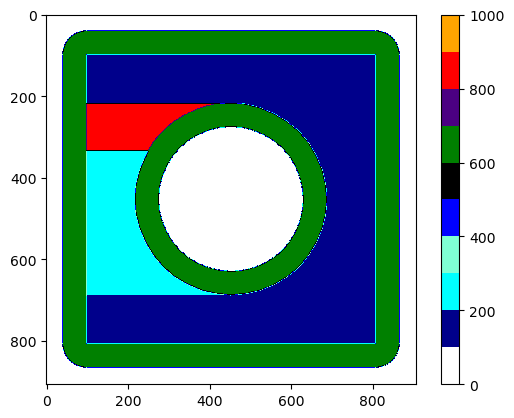

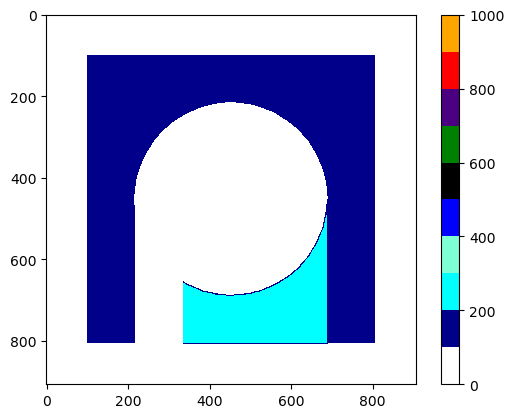

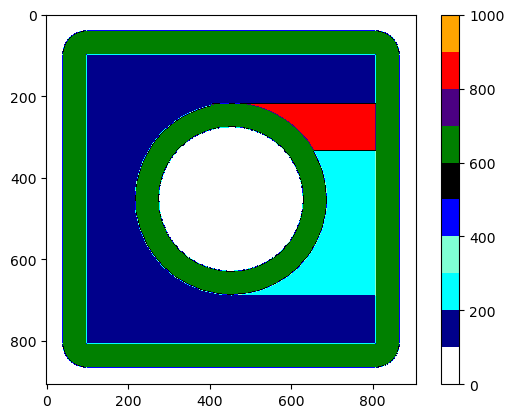

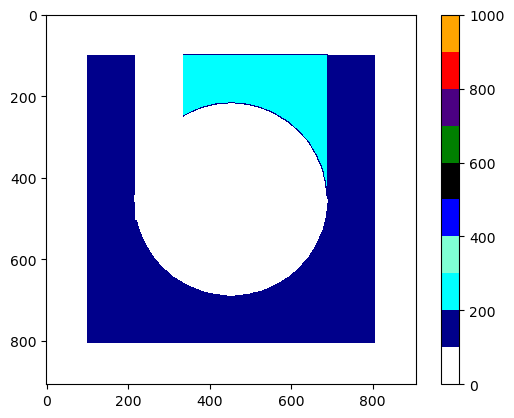

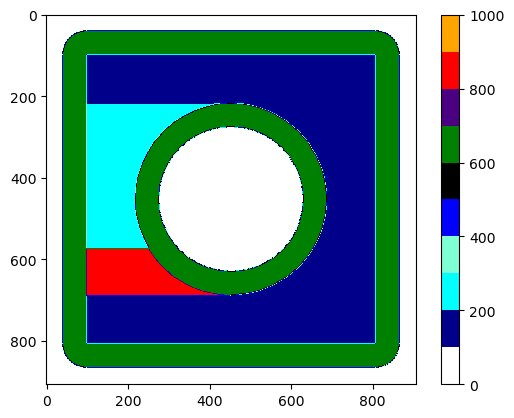

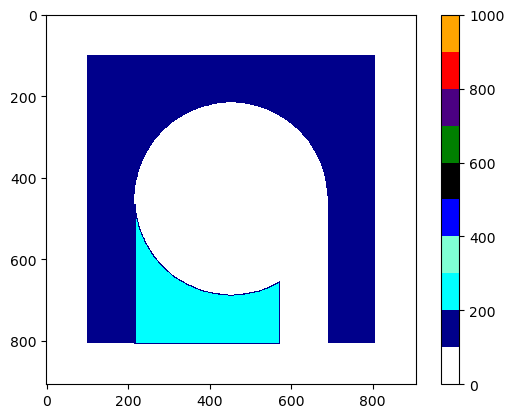

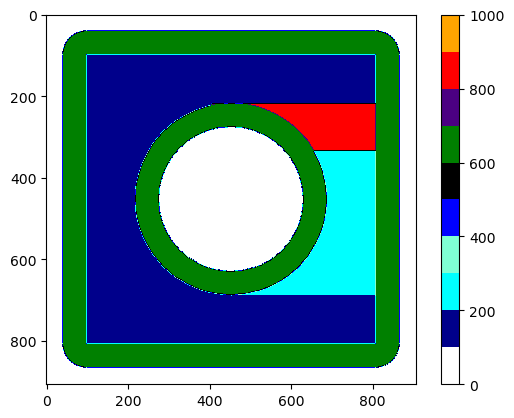

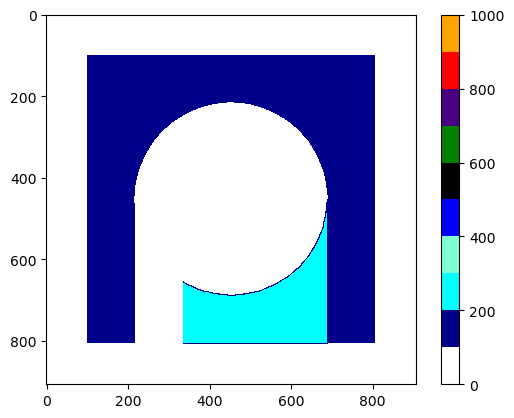

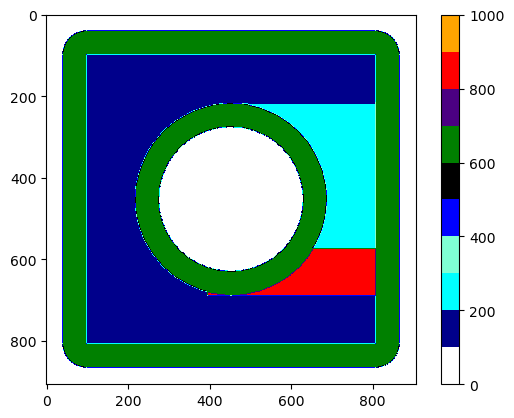

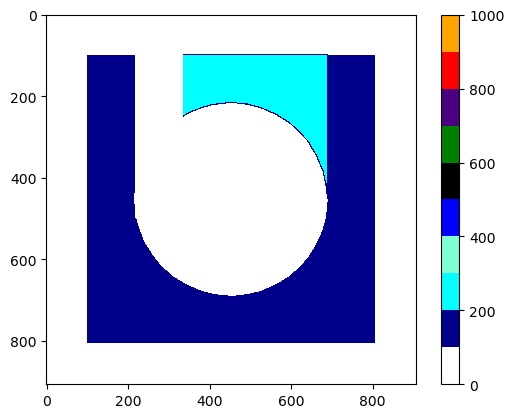

In [15]:
import gui
import files
from timer import Timer
from components import images_tools as it
from os import getcwd
import matplotlib.pyplot as plt
import matplotlib.colors
import os

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for c in camadas:
    folders.load_islands_hdf5(c)
tangran_cmap = matplotlib.colors.ListedColormap(["white","darkblue","aqua","aquamarine","blue","black","green","indigo","red","orange"])
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        plt.figure()
        img_mapping = it.final_mapping(c, folders)
        if i%2 == 1:
            img_mapping = it.rotate_img_ccw(img_mapping )
        plt.imshow(img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        # plt.imsave("aaa.png",img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.colorbar()
        print('\n')

ROTAS

Rotas de Offset

In [30]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

amendment_size = 0.7 #porcentagem do tamanho da poca de deposicao de material
for c in camadas:
    with Timer("Making offset routes"):
        c.make_offset_routes(amendment_size, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.05723404884338379
Total de [Making offset routes] : 2.7165420055389404
Making offset routes
Total de [Making offset routes] : 0.04442572593688965


KeyboardInterrupt: 

Rotas de pontes

In [17]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making bridges routes"):
        c.make_bridges_routes(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0715935230255127
Total de [Making bridges routes] : 0.37433815002441406
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0866401195526123
Total de [Making bridges routes] : 0.3874199390411377
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.08752322196960449
Total de [Making bridges routes] : 0.4325215816497803
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.06594133377075195
Total de [Making bridges routes] : 0.38153815269470215
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.05991220474243164
Total de [Making bridges routes] : 0.3715662956237793
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.05916905403137207
Total de [Making bridges routes] : 0.3836550712585449
Making bridges routes


Rotas de Ziguezague

In [18]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making zigzag routes"):
        c.make_zigzag_routes(folders)
        c.connect_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"



Making zigzag routes
criando as rotas de zigzag, camada:L_000
fazendo as tres opções:
Total de [fazendo as tres opções:] : 6.730731010437012
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.3267641067504883
fazendo as tres opções:
Total de [fazendo as tres opções:] : 10.453762531280518
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.3133552074432373
Total de [criando as rotas de zigzag, camada:L_000] : 19.51972532272339
salvando imagens das rotas
deletado: /L_000/I_000/zigzags
Total de [salvando imagens das rotas] : 0.07434654235839844
Criando os grafos de regiões
Total de [Criando os grafos de regiões] : 0.010392427444458008
Conectando regiões de zigzag
Total de [Conectando regiões de zigzag] : 0.0032868385314941406
salvando grafos
Total de [salvando grafos] : 0.15229582786560059
Total de [Making zigzag routes] : 19.99678874015808
Making zigzag routes
criando as rotas de zigzag, camada:L_001
fazendo as tres opções:
Total de [fazendo as tres opções:] : 5.982475

In [19]:
#WEAVING

import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[iwflag] = gui.ask_parameters_weaving()
for c in camadas:
    with Timer("Fase 5 b"):
        c.internal_weaving(iwflag, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 1.6970245838165283
salvando rotas
deletado: /L_000/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.22152924537658691
Total de [Fase 5 b] : 1.9264233112335205
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 1.8010730743408203
salvando rotas
deletado: /L_001/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.1373143196105957
Total de [Fase 5 b] : 1.9394257068634033
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 1.530195713043213
salvando rotas
deletado: /L_002/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.14897823333740234
Total de [Fase 5 b] : 1.6804397106170654
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 2.006666898727417
salvando rotas
deletado: /L_003/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.1120607852935791
Total

Rotas de Thin Walls

In [20]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making thin walls routes"):
            c.make_thin_wall_routes(folders)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.0377960205078125
salvando imagens das rotas
Total de [salvando imagens das rotas] : 4.363059997558594e-05
Total de [Making thin walls routes] : 0.03885054588317871
Total de [Fase 5] : 0.03909039497375488
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.04161548614501953
salvando imagens das rotas
Total de [salvando imagens das rotas] : 2.3365020751953125e-05
Total de [Making thin walls routes] : 0.04224562644958496
Total de [Fase 5] : 0.04232287406921387
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.03646516799926758
salvando imagens das rotas
Total de [salvando imagens das rotas] : 5.14984130859375e-05
Total de [Making thin walls routes] : 0.037431955337524414
Total de [Fase 5] : 0.03749728202819824
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.059279680252075195
salvando imagens das rotas
Total de [salva

Unificando rotas EXTERNAS nas camadas

In [21]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 6"):
        c.close_routes_external(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"
    

Fase 6
Conectando rotas externas
Encontrando ponto de união ext-int
47
48
49
50
51
52
53
54
Total de [Encontrando ponto de união ext-int] : 0.49318504333496094
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 1.4870257377624512
Conectando pontes de Crossover
Total de [Conectando pontes de Crossover] : 0.0002906322479248047
Total de [Conectando rotas externas] : 2.1954736709594727
salvando imagens das rotas
ERRO: não deletou a coisa
ERRO: não deletou a coisa
Total de [salvando imagens das rotas] : 0.3049800395965576
Total de [Fase 6] : 2.50142240524292
Fase 6
Conectando rotas externas
Encontrando ponto de união ext-int
47
48
49
50
51
52
53
54
Total de [Encontrando ponto de união ext-int] : 0.37270450592041016
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 1.589538335800171
Conectando pontes de Crossover
Total de [Conectando pontes de Crossover] : 0.00011444091796875
Total de [Conectando rotas externas] : 2.160165548324585
salvando imagens das ro

Unificando rotas INTERNAS nas camadas

In [22]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 7"):
        c.close_routes_internal(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 7.0511345863342285
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.016702651977539062
salvando imagens das rotas
ERRO: não deletou a coisa
Total de [salvando imagens das rotas] : 0.4736306667327881
Total de [Fase 7] : 7.834429502487183
Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 3.523944616317749
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.0034661293029785156
salvando imagens das rotas
ERRO: não deletou a coisa
Total de [salvando imagens das rotas] : 0.19984054565429688
Total de [Fase 7] : 3.95115327835083
Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 3.8058629035949707
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.004267692565917969
salvando imagens das rotas
ERRO: não deletou a coisa
Total de [salvando imagens das rotas] : 0.24875307083129883
Total de [Fase 7] : 4.301453113555908


Unindo rotas de thin walls

In [23]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 8"):
        c.close_routes_thinwalls(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0007741451263427734
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0798344612121582
Total de [Fase 8] : 0.11378216743469238
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0012540817260742188
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.09811162948608398
Total de [Fase 8] : 0.13541173934936523
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.000514984130859375
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0752403736114502
Total de [Fase 8] : 0.10866117477416992
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0007045269012451172
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0815591812133789
Total de [Fase 8] : 0.11756086349487305
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0010190010070800781
salvando imagens das rotas

Unindo todas as rotas e criando codigo G

In [24]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[vel_int, vel_ext, vel_thin_wall, p_religamento, p_desligamento, vel_vazio, p_entre_camadas, substratoy, substratox, cortey, cortex] = gui.ask_parameters_Gcode()
coords_substrato = [substratoy, substratox]
coords_corte = [cortey, cortex]
camadas = folders.load_layers_hdf5()

internal_trees = []
external_trees = []
tw_trees = []
for c in camadas:
    folders.load_islands_hdf5(c)
    for isl in c.islands:
        folders.load_island_paths_hdf5(c.name, isl)
        
for c in camadas:
    c.close_final_path(folders)
    for isl in c.islands:
        internal_trees.append([list(x) for x in isl.internal_tree_route.sequence])
        external_trees.append([list(x) for x in isl.external_tree_route.sequence])
        tw_trees.append([list(x) for x in isl.thinwalls_tree_route.sequence])

layer_heights = [10+2.9+3+(i*1.5) for i,x in enumerate(camadas)]
with Timer("Cuspindo o Gcode"):
    path_tools.layers_to_Gcode(camadas, 
                               folders, 
                               vel_int,
                               vel_ext, 
                               vel_thin_wall, 
                               internal_trees,
                               external_trees,
                               tw_trees,
                               p_religamento,
                               p_desligamento,
                               vel_vazio,
                               p_entre_camadas,
                               layer_heights,
                               coords_substrato,
                               coords_corte,
                               )
%reset_selective -f "camadas"

Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.008800506591796875
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.011826515197753906
layer rotacionada
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.010437250137329102
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.01706671714782715
layer rotacionada
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.00937509536743164
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.011911869049072266
layer rotacionada
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.009598493576049805
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.008942127227783203
layer rotacionada
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.008504152297973633
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.010760068893432617
layer rotacionada
Cuspindo o Gcode
trocou para 1
t

In [25]:
import numpy as np
camadas = folders.load_layers_hdf5()
for c in camadas:
    folders.load_islands_hdf5(c)
    for isl in c.islands:
        folders.load_island_paths_hdf5(c.name, isl)
        internal_trees = [list(x) for x in isl.internal_tree_route.sequence]
        print(internal_trees)
print([235,807] in internal_trees)

[[783, 783], [782, 783], [781, 783], [780, 783], [779, 783], [778, 783], [777, 783], [776, 783], [775, 783], [774, 783], [773, 783], [772, 783], [771, 783], [770, 783], [769, 783], [768, 783], [767, 783], [766, 783], [765, 783], [764, 783], [763, 783], [762, 783], [761, 783], [760, 783], [759, 783], [758, 783], [757, 783], [756, 783], [755, 783], [754, 783], [753, 783], [752, 783], [751, 783], [750, 783], [749, 783], [748, 783], [747, 783], [746, 783], [745, 783], [744, 783], [743, 783], [742, 783], [741, 783], [740, 783], [739, 783], [738, 782], [737, 781], [736, 780], [735, 779], [734, 778], [733, 777], [732, 776], [731, 775], [730, 774], [729, 775], [728, 776], [727, 777], [726, 778], [725, 779], [724, 780], [723, 781], [722, 782], [721, 783], [720, 784], [719, 784], [718, 784], [717, 784], [716, 784], [715, 784], [714, 784], [713, 784], [712, 784], [711, 784], [710, 784], [709, 784], [708, 784], [707, 784], [706, 784], [705, 784], [704, 784], [703, 784], [702, 784], [701, 784], [70

In [26]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Lista de imagens binárias (exemplo com arrays numpy)
# imagens = [
#     img_mapping,
#     img_mapping,
#     img_mapping
# ]

# # Lista de alturas no eixo z
# alturas = [0, 10, 20]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for img, z in zip(imagens, alturas):
#     x = np.linspace(0, img.shape[1], img.shape[1])
#     y = np.linspace(0, img.shape[0], img.shape[0])
#     x, y = np.meshgrid(x, y)
#     z = np.full_like(x, z)
#     ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(img), shade=False)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()


In [27]:
# import gui
# import files
# from timer import Timer
# from components import layer, path_tools
# from os import getcwd

# if not('folders' in globals()):
#     home = getcwd()
#     folders = files.System_Paths(home)
#     gui.find_saved_file(folders)
# camadas = folders.load_layers_hdf5()

# file_name = gui.find_saved_file(folders)
# path_tools.layers_to_Gcode_FFF(camadas, folders, file_name)

In [28]:
class TrafficLightState:
    """Base class for traffic light states."""
    def change(self, traffic_light):
        raise NotImplementedError("This method should be overridden by subclasses")


class RedState(TrafficLightState):
    """State representing the red light."""
    def change(self, traffic_light):
        print("Changing from Red to Green")
        traffic_light.state = GreenState()


class YellowState(TrafficLightState):
    """State representing the yellow light."""
    def change(self, traffic_light):
        print("Changing from Yellow to Red")
        traffic_light.state = RedState()


class GreenState(TrafficLightState):
    """State representing the green light."""
    def change(self, traffic_light):
        print("Changing from Green to Yellow")
        traffic_light.state = YellowState()


class TrafficLight:
    """Traffic light class that uses a state machine."""
    def __init__(self):
        self.state = RedState()  # Initial state

    def change(self):
        """Change the state of the traffic light."""
        self.state.change(self)

    def __str__(self):
        return f"Current state: {self.state.__class__.__name__}"


# Example usage
if __name__ == "__main__":
    traffic_light = TrafficLight()
    
    # Simulate the traffic light changing states
    for _ in range(6):  # Change state 6 times
        print(traffic_light)
        traffic_light.change()

Current state: RedState
Changing from Red to Green
Current state: GreenState
Changing from Green to Yellow
Current state: YellowState
Changing from Yellow to Red
Current state: RedState
Changing from Red to Green
Current state: GreenState
Changing from Green to Yellow
Current state: YellowState
Changing from Yellow to Red


In [29]:
import numpy as np
import cv2  # Assuming you are using OpenCV for image processing

def bobobo(image1, image2):
    """A placeholder function that performs some operation on two images."""
    # For demonstration, let's just return the absolute difference between the two images
    return cv2.absdiff(image1, image2)

def process_images(image_list):
    """Process a list of images, comparing the last two with the current image."""
    for i in range(len(image_list)):
        current_image = image_list[i]
        
        # Check if there are at least two previous images to compare
        if i >= 2:
            last_image = image_list[i - 1]
            second_last_image = image_list[i - 2]
            
            # Apply the bobobo function to the current image and the last two images
            result_last = bobobo(current_image, last_image)
            result_second_last = bobobo(current_image, second_last_image)
            
            # Here you can do something with the results, like saving or displaying them
            # For demonstration, we'll just print the shapes of the results
            print(f"Comparing image {i} with last image {i-1}: result shape = {result_last.shape}")
            print(f"Comparing image {i} with second last image {i-2}: result shape = {result_second_last.shape}")

# Example usage
if __name__ == "__main__":
    # Create a list of dummy images (for demonstration purposes)
    # In practice, you would load your images using cv2.imread or similar
    image_list = [np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8) for _ in range(5)]
    
    process_images(image_list)

Comparing image 2 with last image 1: result shape = (100, 100, 3)
Comparing image 2 with second last image 0: result shape = (100, 100, 3)
Comparing image 3 with last image 2: result shape = (100, 100, 3)
Comparing image 3 with second last image 1: result shape = (100, 100, 3)
Comparing image 4 with last image 3: result shape = (100, 100, 3)
Comparing image 4 with second last image 2: result shape = (100, 100, 3)
